In [1]:
# encoding: utf-8

import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc
import os
import psutil
import re

from optparse import OptionParser

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing/')
from Metric import *
from Visualization import *
from Data_Extractor import *


parser = OptionParser()
parser.add_option("--dir", dest="dir")
(options, args) = parser.parse_args(["--dir", "./Log/Classifier_Report/"])

log_dir = options.dir

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def get_metric_on_log(log, record):
    line = [s for s in log if ('balanced_acc' in s and 'AUC' in s and 'avg_precision' in s)][0].split()
    assert line[0] == 'balanced_acc' and line[3] == 'AUC' and line[6] == 'avg_precision'
    
    record['BA'] = float(line[2])
    record['AUC'] = float(line[5])
    record['AP'] = float(line[8])
    
record_list = []
cnt = 0
for filename in os.listdir(log_dir):
    if 'FCN' not in filename: continue
    cnt += 1
    print(cnt, " : ", filename)

    # open file
    file = open(log_dir+filename)
    log = file.read().split('\n')
    file.close()

    # initialization
    record = {}
    record['train'] = {}
    record['val'] = {}
    record['test'] = {}
    
    # name
    record['name'] = filename

    # setting
    record['weight'] = filename.find('weight') > 0
    if filename.find('_G') > 0:
        record['norm_T'] = 'std'
    elif filename.find('_m') > 0:
        record['norm_T'] = 'mean'
    else:
        record['norm_T'] = '-'
        
    record['pos'] = int(filename.split('_p')[1].split('_')[0])
    
    try:
        train_idx = log.index("On train set")    
        val_idx = log.index("On cv set")
        test_idx = log.index("On test set")
    
        get_metric_on_log(log[train_idx:val_idx], record['train'])
        get_metric_on_log(log[val_idx:test_idx], record['val'])
        get_metric_on_log(log[test_idx:], record['test'])

#         print(record)
        record_list.append(record)
    except:
        print('not finished ---------------')

1  :  FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-13
2  :  FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-13
3  :  FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-13
4  :  FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-24
not finished ---------------
5  :  FCN_32-64-128_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-24
not finished ---------------
6  :  FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-21
not finished ---------------


In [40]:
sorted_record_list = sorted(record_list, key=lambda r: (r['name'], r['test']['AUC']))
sorted_record_list

[{'name': 'Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_bn_p0_e20_r0',
  'norm_T': 'std',
  'pos': 0,
  'test': {'AP': 0.135486540948, 'AUC': 0.868387400216, 'BA': 0.774516819851},
  'train': {'AP': 0.166080926526, 'AUC': 0.837989649055, 'BA': 0.723262533414},
  'val': {'AP': 0.207462921733, 'AUC': 0.849917211293, 'BA': 0.753913980101},
  'weight': True},
 {'name': 'Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0',
  'norm_T': 'std',
  'pos': 0,
  'test': {'AP': 0.168574325577, 'AUC': 0.892551335581, 'BA': 0.80679835194},
  'train': {'AP': 0.221942362963, 'AUC': 0.887395038841, 'BA': 0.799105763522},
  'val': {'AP': 0.239194778425, 'AUC': 0.8777221842, 'BA': 0.791626727517},
  'weight': True},
 {'name': 'Incep_1-32|1-64|1-128_G_weight_bn_p0_e20_r0',
  'norm_T': 'std',
  'pos': 0,
  'test': {'AP': 0.0859579050241, 'AUC': 0.824621456639, 'BA': 0.721848467176},
  'train': {'AP': 0.0624664779167,
   'AUC': 0.724332998824,
   'BA': 0.632648114365},
  'val': {'AP': 0.13266691129, 

In [33]:
name_list = ['A', 'C', 'B', 'D']
for r, n in zip(sorted_record_list,name_list):
    r['label'] = n
sorted_record_list = sorted_record_list =sorted(record_list, key=lambda r: (r['label']))

In [41]:
print("BA: train val test | AP: train val test | AUC: train val test ")
for r in sorted_record_list:
    print("%-6.3f & %-4.3f & %-5.3f & %-6.3f & %-4.3f & %-5.3f & %-6.3f & %-4.3f & %-5.3f \\\\ %% %s"  % 
         (r['train']['BA'], r['val']['BA'], r['test']['BA'],
          r['train']['AP'], r['val']['AP'], r['test']['AP'],
          r['train']['AUC'], r['val']['AUC'], r['test']['AUC'],
          r['name']))

BA: train val test | AP: train val test | AUC: train val test 
0.723  & 0.754 & 0.775 & 0.166  & 0.207 & 0.135 & 0.838  & 0.850 & 0.868 \\ % Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_bn_p0_e20_r0
0.799  & 0.792 & 0.807 & 0.222  & 0.239 & 0.169 & 0.887  & 0.878 & 0.893 \\ % Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0
0.633  & 0.684 & 0.722 & 0.062  & 0.133 & 0.086 & 0.724  & 0.780 & 0.825 \\ % Incep_1-32|1-64|1-128_G_weight_bn_p0_e20_r0
0.693  & 0.673 & 0.756 & 0.072  & 0.122 & 0.073 & 0.771  & 0.765 & 0.835 \\ % Incep_1-32|1-64|1-128_G_weight_p0_e20_r0
0.715  & 0.728 & 0.780 & 0.138  & 0.180 & 0.123 & 0.822  & 0.836 & 0.863 \\ % Incep_3-32;1-32|3-64;1-64_G_weight_bn_p0_e20_r0
0.767  & 0.753 & 0.785 & 0.154  & 0.174 & 0.113 & 0.854  & 0.842 & 0.873 \\ % Incep_3-32;1-32|3-64;1-64_G_weight_p0_e20_r0
0.715  & 0.730 & 0.764 & 0.147  & 0.189 & 0.119 & 0.815  & 0.840 & 0.838 \\ % Incep_3-32;1-32|3-64;1-64_m_weight_bn_p0_e20_r0
0.733  & 0.723 & 0.780 & 0.180  & 0.202 & 0.153 

[array([0., 1., 2.]), array([0.15, 1.15, 2.15]), array([0.3, 1.3, 2.3]), array([0.45, 1.45, 2.45])]
Incep_1-32|1-64|1-128_G_weight_bn_p0_e20_r0
Incep_3-32|3-64|3-128_G_weight_p0_e20_r0
Incep_3-32;1-32|3-64;1-64_m_weight_bn_p0_e20_r0
Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0


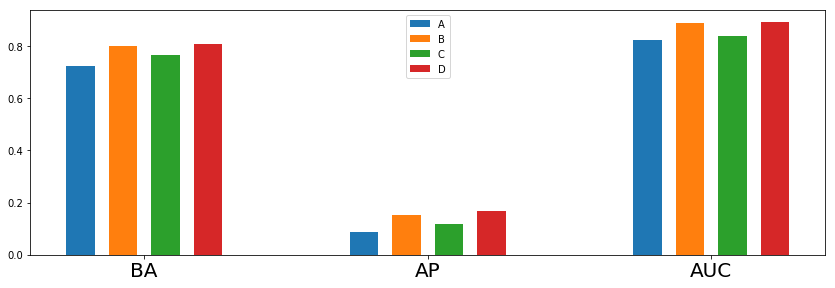

[<Container object of 3 artists>, <Container object of 3 artists>, <Container object of 3 artists>, <Container object of 3 artists>]
['A', 'B', 'C', 'D']


In [35]:
file_num = 4
width = 0.1
key_list = ['BA', 'AP', 'AUC']

fig, ax = plt.subplots(figsize=(9.5*1.5,3*1.5))
placement = np.arange(len(key_list))
placement = [cnt*0.15 + placement for cnt in range(file_num)]
print(placement)

cnt = 0

name_list = []
plot_list = []
for r in sorted_record_list:

    print('%-30s' % (r['name']), end='')
    if 'weight' not in r['name']: 
        print('%20s' % ('--- skip'))
        continue
    print()
    
    val_list = []
    for key in key_list:
        val_list.append(r['test'][key])

#     if r['pos'] < 8:
#         if r['weight']: name = 'weight'
#         else: name = '-'
#     elif r['pos'] == 8: name = '0.125'
#     elif r['pos'] == 16: name = '0.250'
#     elif r['pos'] == 32: name = '0.500'

    name = r['label']
    name_list.append(name)

    plot_list.append(ax.bar(placement[cnt], val_list, width=width))
    cnt += 1

ax.set_xticks((placement[int(cnt/2)] + placement[int(cnt/2)-1])/2)
ax.set_xticklabels(key_list, fontdict={'fontsize': 20})

# legend experiment name
ax.legend([bar[0] for bar in plot_list], name_list)
plt.savefig('./Result/Incep_bar', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

print(plot_list)
print(name_list)

In [18]:
print(placement)
(placement[int(cnt/2)] + placement[int(cnt/2)-1])/2

[array([0., 1., 2.]), array([0.15, 1.15, 2.15]), array([0.3, 1.3, 2.3]), array([0.45, 1.45, 2.45])]


array([0.225, 1.225, 2.225])

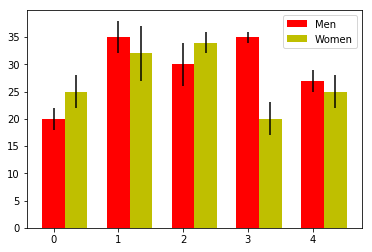

In [56]:
N = 5
men_means = (20, 35, 30, 35, 27)
men_std = (2, 3, 4, 1, 2)
women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, ax = plt.subplots()

plot_list = []
plot_list.append(ax.bar(ind, men_means, width, color='r', yerr=men_std))

plot_list.append(ax.bar(ind + width, women_means, width, color='y', yerr=women_std))

name_list = ['Men', 'Women']
ax.legend([bar[0] for bar in plot_list], name_list)


plt.show()